<a href="https://colab.research.google.com/github/vircsinger625/Onlab_2020_2/blob/main/%C3%96nlab_3Kutya_StanfordDogsDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [ ]:
!pip install torch
!pip install torchvision

In [3]:
## A szükséges importálások elvégzése

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import itertools
import time

import os, sys
import cv2
from PIL import Image

from torch.autograd import Variable

from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt

In [4]:
# A képek megjelenítéséhez szükséges függyvény

def imshow(img):  #:param img: (PyTorch Tensor)
    img = img / 2 + 0.5                           # unnormalize
    npimg = img.numpy()                           # Convert tensor to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))    # Color channel first -> color channel last
    plt.show()

In [ ]:
#Új mappa létrehozása az adatok lementéséhez

%cd /home 
!ls
!mkdir -p StanfordDogsDataset
%cd /home/StanfordDogsDataset

In [ ]:
## Az adatbázis letöltése linux serverre a wget linux command segítségével, ha még nem létezik az adott file
!wget -nc http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar -P /home/StanfordDogsDataset/
!wget -nc http://vision.stanford.edu/aditya86/ImageNetDogs/train_data.mat -P /home/StanfordDogsDataset/
!wget -nc http://vision.stanford.edu/aditya86/ImageNetDogs/test_data.mat -P /home/StanfordDogsDataset/
!wget -nc http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar -P /home/StanfordDogsDataset/
!wget -nc http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar -P /home/StanfordDogsDataset/
!wget -nc http://vision.stanford.edu/aditya86/ImageNetDogs/README.txt -P /home/StanfordDogsDataset/

In [ ]:
## tar fájlok kibontása

!tar -xvf images.tar 
!tar -xvf annotation.tar 
!tar -xvf lists.tar

!ls

In [8]:
num_workers = 2
batch_size= 100
test_batch_size = 4

Képek beolvasása

In [9]:
## Az összes kép betöltése
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
     transforms.Resize((227, 227))    #resize image to 227 x 227 because the input image resolution for AlexNet is 227 x 227

     ]) 

imgs_dir = '/home/StanfordDogsDataset/Images'
imagenet_data = torchvision.datasets.ImageFolder(imgs_dir, transform=transform)
total_images_num = len(imagenet_data)

In [11]:
## A tanító, teszetelő és validációs adathalmazok szerinti adatbetöltés

train_data, test_data, val_data = torch.utils.data.random_split(imagenet_data, [16464, 2058, 2058], generator=torch.Generator().manual_seed(42))

train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                        batch_size = batch_size,
                                        shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size, 
                                      shuffle = False)


val_gen = torch.utils.data.DataLoader(dataset = val_data,
                                      batch_size = batch_size, 
                                      shuffle = False)

In [12]:
all_data = len(train_data)+len(test_data)+len(val_data)
total_images_num = len(imagenet_data)
num_classes = len(os.listdir(imgs_dir))

print(all_data == total_images_num)

print('Classes: %d' % (num_classes))
print("Images number: %d" % (total_images_num))

print('Train Data: \t %.3f%%' %torch.true_divide(100*len(train_data),all_data), '\t Number of images: ', len(train_data))
print('Test  Data: \t %.3f%%' %torch.true_divide(100*len(test_data),all_data), '\t Number of images:  ', len(test_data))
print('Valid Data: \t %.3f%%' %torch.true_divide(100*len(val_data),all_data), '\t Number of images:  ', len(val_data))

True
Classes: 120
Images number: 20580
Train Data: 	 80.000% 	 Number of images:  16464
Test  Data: 	 10.000% 	 Number of images:   2058
Valid Data: 	 10.000% 	 Number of images:   2058


In [16]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

classes, class_to_idx = find_classes(imgs_dir)

In [ ]:
## Az összes kutyafajta kilistázása (osztályok)
for i in range(0, num_classes): 
  print("{}-{}".format(i, classes[i][10:]))

Adatok az adatbázisról és képek kirajzolása 

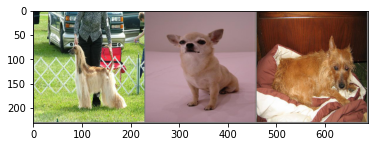

            9             0            42
 Afghan_hound     Chihuahua Australian_terrier


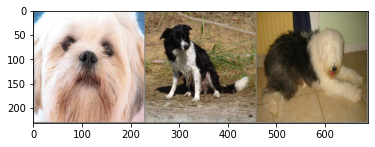

           53            81            78
        Lhasa Border_collie Old_English_sheepdog


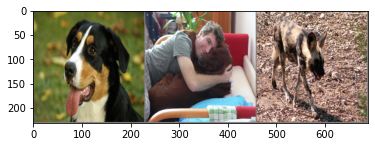

           89            62           119
  Appenzeller  Irish_setter African_hunting_dog


In [67]:
num_img = 3
# get some random training images
dataiter = iter(train_gen)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:num_img,:,:,:],  nrow = num_img))
# print labels
print(' '.join('{:>13}'.format(labels[j]) for j in range(num_img)))
print(' '.join('{:>13}'.format(classes[labels[j]][10:]) for j in range(num_img)))

dataiter = iter(test_gen)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:num_img,:,:,:],  nrow = num_img))
# print labels
print(' '.join('{:>13}'.format(labels[j]) for j in range(num_img)))
print(' '.join('{:>13}'.format(classes[labels[j]][10:]) for j in range(num_img)))

dataiter = iter(val_gen)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:num_img,:,:,:],  nrow = num_img))
# print labels
print(' '.join('{:>13}'.format(labels[j]) for j in range(num_img)))
print(' '.join('{:>13}'.format(classes[labels[j]][10:]) for j in range(num_img)))

## **Tanítás 3 kutyával**

In [ ]:
## 3 fajta kutya képeinek betöltése

%cd /home/StanfordDogsDataset
!mkdir -p dog3_Images
%cd /home/StanfordDogsDataset/dog3_Images

imgs3_dir = '/home/StanfordDogsDataset/dog3_Images'

%cp -R /home/StanfordDogsDataset/Images/n02085936-Maltese_dog /home/StanfordDogsDataset/dog3_Images
%cp -R /home/StanfordDogsDataset/Images/n02087394-Rhodesian_ridgeback /home/StanfordDogsDataset/dog3_Images
%cp -R /home/StanfordDogsDataset/Images/n02105056-groenendael /home/StanfordDogsDataset/dog3_Images


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
     transforms.Resize((227, 227))    #resize image to 227 x 227 because the input image resolution for AlexNet is 227 x 227

     ]) 

imagenet3_data = torchvision.datasets.ImageFolder(imgs3_dir, transform=transform)
total3_images_num = len(imagenet3_data)
print(len(imagenet3_data))

In [ ]:
train3_data, test3_data, val3_data = torch.utils.data.random_split(imagenet3_data, [458, 58, 58], generator=torch.Generator().manual_seed(42))


train3_gen = torch.utils.data.DataLoader(dataset = train_data3,
                                        batch_size = batch_size,
                                        shuffle = True)

test3_gen = torch.utils.data.DataLoader(dataset = test_data3,
                                      batch_size = batch_size, 
                                      shuffle = False)


val3_gen = torch.utils.data.DataLoader(dataset = val_data3,
                                      batch_size = batch_size, 
                                      shuffle = False)

classes3, class3_to_idx = find_classes(imgs3_dir)

for i in range(0, len(os.listdir(imgs3_dir))): 
  print("{}-{}".format(i, classes[i][10:]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


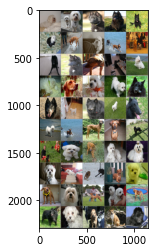

            0             0             2             2             2             0             1             0             1             1             2             2             1             2             0             0             1             0             0             2             2             0             2             0             2             0             1             1             1             2             2             0             1             0             0             0             0             1             1             0             1             0             1             0             1             2             0             1             1             2
  Maltese_dog   Maltese_dog   groenendael   groenendael   groenendael   Maltese_dog Rhodesian_ridgeback   Maltese_dog Rhodesian_ridgeback Rhodesian_ridgeback   groenendael   groenendael Rhodesian_ridgeback   groenendael   Maltese_dog   Maltese_dog Rhodesian_ridgeback   Maltese_dog   Maltese_dog   gr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


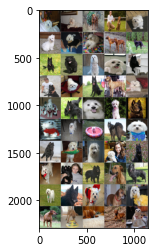

            0             0             1             1             0             0             0             0             1             2             2             2             0             0             2             2             0             2             1             0             0             2             0             0             2             0             0             0             2             0             2             0             0             0             2             0             2             2             1             2             0             2             0             1             0             1             1             1             1             0
  Maltese_dog   Maltese_dog Rhodesian_ridgeback Rhodesian_ridgeback   Maltese_dog   Maltese_dog   Maltese_dog   Maltese_dog Rhodesian_ridgeback   groenendael   groenendael   groenendael   Maltese_dog   Maltese_dog   groenendael   groenendael   Maltese_dog   groenendael Rhodesian_ridgeback   Maltese_

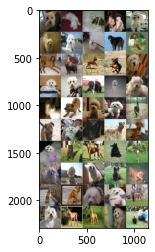

            0             0             0             0             0             0             0             0             2             1             1             2             1             1             0             0             0             2             0             0             0             1             0             0             2             1             0             2             1             1             0             2             1             2             1             0             0             0             2             1             1             1             0             0             1             0             1             1             0             2
  Maltese_dog   Maltese_dog   Maltese_dog   Maltese_dog   Maltese_dog   Maltese_dog   Maltese_dog   Maltese_dog   groenendael Rhodesian_ridgeback Rhodesian_ridgeback   groenendael Rhodesian_ridgeback Rhodesian_ridgeback   Maltese_dog   Maltese_dog   Maltese_dog   groenendael   Maltese_dog   Maltese_

In [68]:
num_img = 50
# get some random training images
dataiter = iter(train3_gen)
images3, labels3 = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images3[0:num_img,:,:,:],  nrow = 5))
# print labels
print(' '.join('{:>13}'.format(labels3[j]) for j in range(num_img)))
print(' '.join('{:>13}'.format(classes3[labels3[j]][10:]) for j in range(num_img)))

dataiter = iter(test3_gen)
images3, labels3 = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images3[0:num_img,:,:,:],  nrow = 5))
# print labels
print(' '.join('{:>13}'.format(labels3[j]) for j in range(num_img)))
print(' '.join('{:>13}'.format(classes3[labels3[j]][10:]) for j in range(num_img)))

dataiter = iter(val3_gen)
images3, labels3 = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images3[0:num_img,:,:,:],  nrow = 5))
# print labels
print(' '.join('{:>13}'.format(labels3[j]) for j in range(num_img)))
print(' '.join('{:>13}'.format(classes3[labels3[j]][10:]) for j in range(num_img)))

Eredmények